# MULTI-GPU TRAINING (WORK-IN-PROGRESS)


**Notes as of 2018-03-11** Attempted multi-gpu training using [Keras multi_gpu_model()](https://keras.io/utils/) capability. Tested on AWS p2.8xlarge instance with 8 Nvidia K80 gpus. Encountered one problem:

ModelChekcpoint call-back to save best weights did not work in muti-gpu mode. Disabled that call-back. More research needed to see how this could work with multiple gpus.  See issues [#9548](https://github.com/keras-team/keras/issues/9548) and [#8764](https://github.com/keras-team/keras/issues/8764).

In [1]:
import tensorflow as tf
import keras
keras.__version__

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
Using TensorFlow backend.


'2.1.4'

In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [3]:
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

from keras.utils import multi_gpu_model

In [4]:
from keras import backend as K

## Setup run-time configuration

In [5]:
# training data specific names
base_model_name = './models/vgg16_full_multi_gpu_base_model.h5'
finetuned_model_name = './models/vgg16_full_multi_gpu_finetuned_model.h5'

train_dir = '/mystuff/cats_dogs_data/train_full'

# location for validation and test data
validation_dir = '/mystuff/cats_dogs_data/validation'
test_dir = '/mystuff/cats_dogs_data/test'


# training run specific parameters
NUMBER_GPUS = 8
BASE_MODEL_EPOCHS=30
FINETUNED_MODEL_EPOCHS=50
BATCH_SIZE = 1024

TRAIN_SAMPLES = len(os.listdir(os.path.join(train_dir,'cats'))) + len(os.listdir(os.path.join(train_dir,'dogs')))
VALIDATION_SAMPLES = len(os.listdir(os.path.join(validation_dir,'cats'))) + \
    len(os.listdir(os.path.join(validation_dir,'dogs')))
    
TEST_SAMPLES = len(os.listdir(os.path.join(test_dir,'cats'))) + len(os.listdir(os.path.join(test_dir,'dogs')))

print('Number of samples: training {:d}, validation {:d} and test {:d}'.format(TRAIN_SAMPLES, 
                                                                               VALIDATION_SAMPLES,TEST_SAMPLES))

Number of samples: training 21000, validation 2000 and test 2000


# Using a pre-trained convnet



## Feature extraction for VGG16 model



In [6]:
from keras.applications import VGG16

In [7]:
with tf.device('/cpu:0'):
    conv_base = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(150, 150, 3))

    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))


58892288/58889256 [==============================] - 1s 0us/step


This is what our model looks like now:

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


### Freeze base model layers

In [9]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [10]:
conv_base.trainable = False

In [11]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


### Setup training data pipeline using data augmenation

In [13]:


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=BATCH_SIZE,  # original
        #batch_size=50,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 21000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


### Train new classifer specific to cat vs dog using features created by baseline model

In [14]:
parallel_model = multi_gpu_model(model, gpus=NUMBER_GPUS)

parallel_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

In [15]:
# set up to capture best performance weights ecountered during training
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('./models/weights_best.hdf5', monitor='val_acc', verbose=1, save_best_only=True,
mode='max')
callbacks_list = [checkpoint]


history = parallel_model.fit_generator(
      train_generator,
      steps_per_epoch=TRAIN_SAMPLES/BATCH_SIZE,
      epochs=BASE_MODEL_EPOCHS,  
      validation_data=validation_generator,
      validation_steps=VALIDATION_SAMPLES/BATCH_SIZE,
      #callbacks=callbacks_list,
      workers=16,   #nproc//2
      use_multiprocessing=True,
      verbose=2)

Epoch 1/30
 - 110s - loss: 0.9432 - acc: 0.5918 - val_loss: 0.4342 - val_acc: 0.8270
Epoch 2/30
 - 26s - loss: 0.4419 - acc: 0.7984 - val_loss: 0.2972 - val_acc: 0.8765
Epoch 3/30
 - 31s - loss: 0.3651 - acc: 0.8417 - val_loss: 0.2544 - val_acc: 0.8990
Epoch 4/30
 - 28s - loss: 0.3381 - acc: 0.8529 - val_loss: 0.2323 - val_acc: 0.9105
Epoch 5/30
 - 32s - loss: 0.3275 - acc: 0.8558 - val_loss: 0.2361 - val_acc: 0.9070
Epoch 6/30
 - 32s - loss: 0.3163 - acc: 0.8593 - val_loss: 0.2203 - val_acc: 0.9105
Epoch 7/30
 - 32s - loss: 0.3077 - acc: 0.8626 - val_loss: 0.2192 - val_acc: 0.9155
Epoch 8/30
 - 31s - loss: 0.3052 - acc: 0.8656 - val_loss: 0.2094 - val_acc: 0.9190
Epoch 9/30
 - 31s - loss: 0.3025 - acc: 0.8670 - val_loss: 0.2248 - val_acc: 0.9100
Epoch 10/30
 - 32s - loss: 0.2947 - acc: 0.8715 - val_loss: 0.2079 - val_acc: 0.9180
Epoch 11/30
 - 31s - loss: 0.2945 - acc: 0.8718 - val_loss: 0.2034 - val_acc: 0.9205
Epoch 12/30
 - 30s - loss: 0.2945 - acc: 0.8711 - val_loss: 0.2039 - val_

In [16]:
# load best performance weights
#model.load_weights('./models/weights_best.hdf5')

# save trained model
model.save(base_model_name)

Examine learning rates:

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


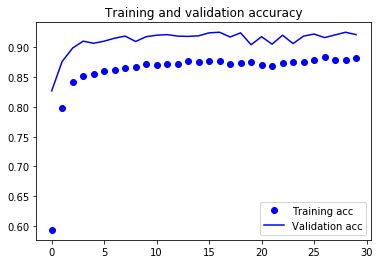

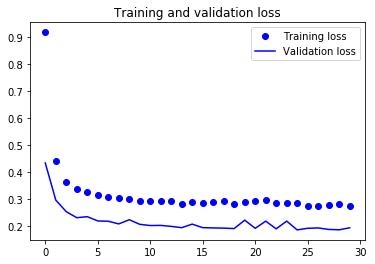

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=BATCH_SIZE,
        class_mode='binary')

test_loss, test_acc = parallel_model.evaluate_generator(test_generator, steps=TEST_SAMPLES/BATCH_SIZE)
print('base model test acc:', test_acc)

Found 2000 images belonging to 2 classes.
base model test acc: 0.9054999923706055


## Fine-tuning



Model before setup for fine tuning

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [21]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [22]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [23]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 15,076,865
Non-trainable params: 1,735,488
_________________________________________________________________



Now let's proceed with fine-tuning:

In [28]:
checkpoint = ModelCheckpoint('./models/weights_best.hdf5', monitor='val_acc', verbose=1, save_best_only=True,
mode='max')
callbacks_list = [checkpoint]


parallel_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),  # use low rate to avoid large changes in cnn layer
              metrics=['acc'])

history = parallel_model.fit_generator(
      train_generator,
      steps_per_epoch=TRAIN_SAMPLES/BATCH_SIZE,
      epochs=FINETUNED_MODEL_EPOCHS,
      validation_data=validation_generator,
      validation_steps=VALIDATION_SAMPLES/BATCH_SIZE,
      #callbacks=callbacks_list,
      workers=16,   #nproc//2
      use_multiprocessing=True,
      verbose=2)

Epoch 1/50
 - 45s - loss: 0.3435 - acc: 0.8662 - val_loss: 0.1728 - val_acc: 0.9320
Epoch 2/50
 - 38s - loss: 0.2557 - acc: 0.8902 - val_loss: 0.1632 - val_acc: 0.9350
Epoch 3/50
 - 38s - loss: 0.2324 - acc: 0.8986 - val_loss: 0.1504 - val_acc: 0.9435
Epoch 4/50
 - 35s - loss: 0.2222 - acc: 0.9032 - val_loss: 0.1245 - val_acc: 0.9510
Epoch 5/50
 - 38s - loss: 0.2077 - acc: 0.9123 - val_loss: 0.1734 - val_acc: 0.9305
Epoch 6/50
 - 37s - loss: 0.1885 - acc: 0.9193 - val_loss: 0.1159 - val_acc: 0.9585
Epoch 7/50
 - 37s - loss: 0.1884 - acc: 0.9199 - val_loss: 0.1615 - val_acc: 0.9385
Epoch 8/50
 - 35s - loss: 0.1800 - acc: 0.9244 - val_loss: 0.1059 - val_acc: 0.9600
Epoch 9/50
Epoch 9/50
 - 36s - loss: 0.1695 - acc: 0.9316 - val_loss: 0.0959 - val_acc: 0.9645
Epoch 10/50
 - 36s - loss: 0.1695 - acc: 0.9316 - val_loss: 0.0959 - val_acc: 0.9645
 - 36s - loss: 0.1623 - acc: 0.9311 - val_loss: 0.0908 - val_acc: 0.9655
Epoch 11/50
Epoch 11/50
 - 37s - loss: 0.1537 - acc: 0.9349 - val_loss: 0.1

In [29]:
#model.load_weights('./models/weights_best.hdf5')
model.save(finetuned_model_name)

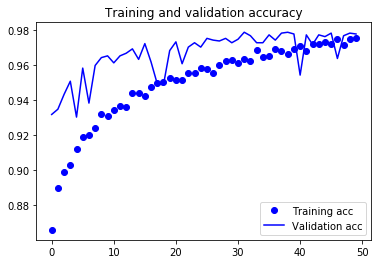

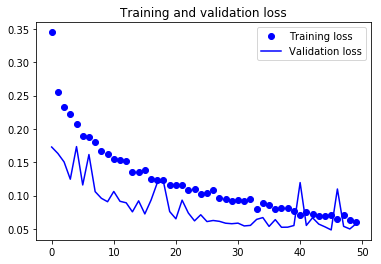

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=BATCH_SIZE,
        class_mode='binary')

test_loss, test_acc = parallel_model.evaluate_generator(test_generator, steps=TEST_SAMPLES/BATCH_SIZE)
print('fine tuned test acc:', test_acc)

Found 2000 images belonging to 2 classes.
fine tuned test acc: 0.9724999942779541


In [32]:
preds = parallel_model.predict_generator(test_generator, steps=TEST_SAMPLES/BATCH_SIZE)
len(preds)

2000